# Examples for OptPulseProcessor

Author: Boxi Li (etamin1201@gmail.com)

In [1]:
from numpy import pi
from qutip import sigmaz, sigmax, identity, basis, fidelity, tensor
from qutip_qip.device import OptPulseProcessor
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import expand_operator, toffoli

The `qutip.OptPulseProcessor` is a noisy quantum device simulator integrated with the optimal pulse algorithm from the `qutip.control` module. It is a subclass of `qutip.Processor` and is equipped with a method to find the optimal pulse sequence (hence the name `OptPulseProcessor`) for a `qutip.QubitCircuit` or a list of `qutip.Qobj`. For the user guide of `qutip.Processor`, please refer to [the introductory notebook](qip-noisy-device-simulator.ipynb).

## Single-qubit gate
Like in the parent class `Processor`, we need to first define the available Hamiltonians in the system. The `OptPulseProcessor` has one more parameter, the drift Hamiltonian, which has no time-dependent coefficients and thus won't be optimized.

In [2]:
num_qubits = 1
# Drift Hamiltonian
H_d = sigmaz()
# The (single) control Hamiltonian
H_c = sigmax()
processor = OptPulseProcessor(num_qubits, drift=H_d)
processor.add_control(H_c, 0)

The method `load_circuit` calls `qutip.control.optimize_pulse_unitary` and returns the pulse coefficients.

********** Gate 0 **********
Final fidelity error 6.248201955827426e-11
Final gradient normal 3.8525826831468874e-05
Terminated due to Goal achieved
Number of iterations 7


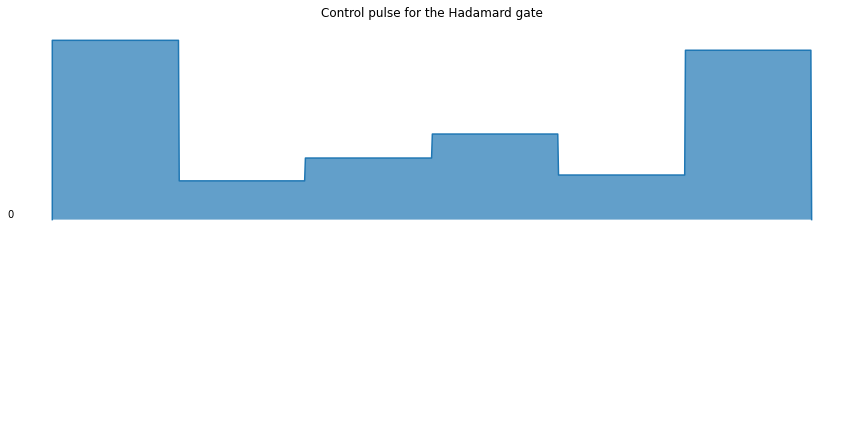

In [3]:
qc = QubitCircuit(num_qubits)
qc.add_gate("SNOT", 0)

# This method calls optimize_pulse_unitary
tlist, coeffs = processor.load_circuit(qc, min_grad=1e-20, init_pulse_type='RND',
                                       num_tslots=6, evo_time=1, verbose=True)
processor.plot_pulses(title="Control pulse for the Hadamard gate", use_control_latex=False);

Like the `Processor`, the simulation is calculated with a QuTiP solver. The method `run_state` calls `mesolve` and returns the result. One can also add noise to observe the change in the fidelity, e.g. the t1 decoherence time.

In [4]:
rho0 = basis(2,1)
plus = (basis(2,0) + basis(2,1)).unit()
minus = (basis(2,0) - basis(2,1)).unit()
result = processor.run_state(init_state=rho0)
print("Fidelity:", fidelity(result.states[-1], minus))

# add noise
processor.t1 = 40.0
result = processor.run_state(init_state=rho0)
print("Fidelity with qubit relaxation:", fidelity(result.states[-1], minus))

Fidelity: 1.0000000052177915
Fidelity with qubit relaxation: 0.9933419853438271


## Multi-qubit gate

In the following example, we use `OptPulseProcessor` to find the optimal control pulse of a multi-qubit circuit. For simplicity, the circuit contains only one Toffoli gate.

In [5]:
toffoli()

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]

We have single-qubit control $\sigma_x$ and $\sigma_z$, with the argument `cyclic_permutation=True`, it creates 3 operators each targeted on one qubit.

In [6]:
N = 3
H_d = tensor([identity(2)] * 3)
test_processor = OptPulseProcessor(N, H_d)
test_processor.add_control(sigmaz(), cyclic_permutation=True)
test_processor.add_control(sigmax(), cyclic_permutation=True)

The interaction is generated by $\sigma_x\sigma_x$ between the qubit 0 & 1 and qubit 1 & 2. `expand_operator` can be used to expand the operator to a larger dimension with given target qubits.

In [7]:
sxsx = tensor([sigmax(),sigmax()])
sxsx01 = expand_operator(sxsx, 3, targets=[0,1])
sxsx12 = expand_operator(sxsx, 3, targets=[1,2])
test_processor.add_control(sxsx01)
test_processor.add_control(sxsx12)

Use the above defined control Hamiltonians, we now find the optimal pulse for the Toffoli gate with 6 time slots. Instead of a `QubitCircuit`, a list of operators can also be given as an input.

In [8]:
def get_control_latex():
    """
    Get the labels for each Hamiltonian.
    It is used in the method``plot_pulses``.
    It is a 2-d nested list, in the plot,
    a different color will be used for each sublist.
    """
    return ([[r"$\sigma_z^%d$" % n for n in range(test_processor.num_qubits)],
             [r"$\sigma_x^%d$" % n for n in range(test_processor.num_qubits)],
             [r"$g_01$", r"$g_12$" ]])
test_processor.model.get_control_latex = get_control_latex

In [9]:
test_processor.dims = [2,2,2]

********** Gate 0 **********
Final fidelity error 2.525584519297297e-08
Final gradient normal 1.9592094768434787e-05
Terminated due to function converged
Number of iterations 262


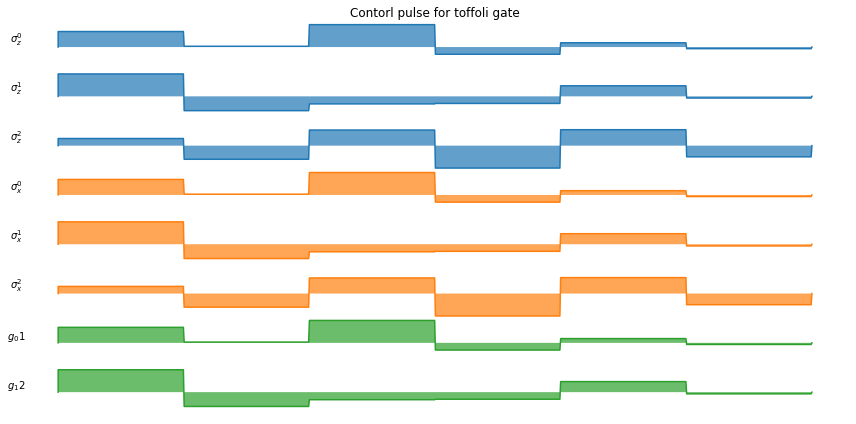

In [10]:
test_processor.load_circuit([toffoli()], num_tslots=6, evo_time=1, verbose=True);

test_processor.plot_pulses(title="Contorl pulse for toffoli gate");

## Merging a quantum circuit
If there are multiple gates in the circuit, we can choose if we want to first merge them and then find the pulse for the merged unitary.

In [11]:
qc = QubitCircuit(3)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("RX", targets=2, arg_value=pi/4)
qc.add_gate("RY", targets=1, arg_value=pi/8)

********** Gate 0 **********
Final fidelity error 9.288031862508817e-07
Final gradient normal 1.0009544656595555e-05
Terminated due to function converged
Number of iterations 351
********** Gate 1 **********
Final fidelity error 3.309241769500204e-12
Final gradient normal 2.303187094527492e-05
Terminated due to Goal achieved
Number of iterations 8
********** Gate 2 **********
Final fidelity error 4.594247204892099e-11
Final gradient normal 7.96388756111269e-06
Terminated due to Goal achieved
Number of iterations 28


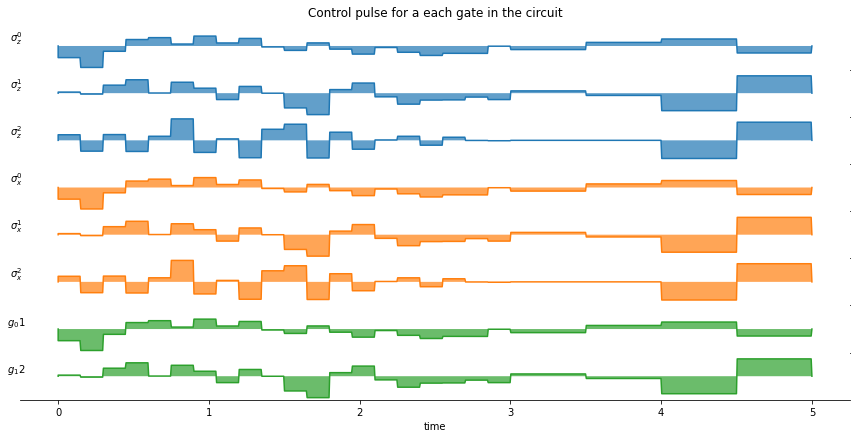

In [12]:
setting_args = {"CNOT": {"num_tslots": 20, "evo_time": 3},
                "RX": {"num_tslots": 2, "evo_time": 1},
                "RY": {"num_tslots": 2, "evo_time": 1}}

test_processor.load_circuit(qc, merge_gates=False, setting_args=setting_args, verbose=True);
fig, axes = test_processor.plot_pulses(title="Control pulse for a each gate in the circuit", show_axis=True);
axes[-1].set_xlabel("time");

In the above figure, the pulses from $t=0$ to $t=3$ are for the CNOT gate while the rest for are the two single qubits gates. The difference in the frequency of change is merely a result of our choice of `evo_time`. Here we can see that the three gates are carried out in sequence.

********** Gate 0 **********
Final fidelity error 1.3890985953723956e-06
Final gradient normal 1.7036117990856595e-05
Terminated due to function converged
Number of iterations 354


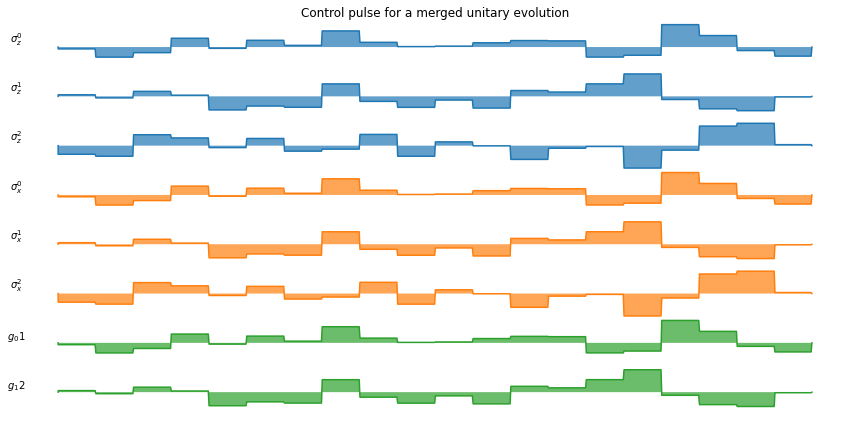

In [13]:
qc = QubitCircuit(3)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("RX", targets=2, arg_value=pi/4)
qc.add_gate("RY", targets=1, arg_value=pi/8)
test_processor.load_circuit(qc, merge_gates=True, verbose=True, num_tslots=20, evo_time=5);
test_processor.plot_pulses(title="Control pulse for a merged unitary evolution");

In this figure there are no different stages, the three gates are first merged and then the algorithm finds the optimal pulse for the resulting unitary evolution.

In [14]:
import qutip_qip
print("qutip-qip version:", qutip_qip.version.version)
from qutip.ipynbtools import version_table
version_table()

qutip-qip version: 0.2.0


Software,Version
QuTiP,4.6.3
Numpy,1.22.2
SciPy,1.8.0
matplotlib,3.5.1
Cython,0.29.27
Number of CPUs,12
BLAS Info,OPENBLAS
IPython,8.0.1
Python,"3.9.0 | packaged by conda-forge | (default, Nov 26 2020, 07:53:15) [MSC v.1916 64 bit (AMD64)]"
OS,nt [win32]
